안녕하세요, 이번 포스팅에서는 **FastText**를 Pytorch를 이용해서 구현해 보겠습니다.   
[저번 포스팅](https://kthworks.github.io/nlp/FastText-%EA%B0%9C%EB%85%90%ED%8E%B8/)에서 기본적인 FastText의 개념에 대해서 다루어 보았는데요.  

간단한 구현을 위해 **Skip-gram 모델을 기준으로, 음절 단위로 subword**를 나누었습니다. 
전반적인 틀은 Word2Vec의 구현과 크게 다르지 않으므로, Word2Vec 구현을 기준으로 추가되거나 바뀌는 부분에 대해서만 설명하도록 하겠습니다. **이번 포스팅에서의 코드에 대한 설명이 부족하시다면 [이 곳](https://kthworks.github.io/nlp/Word2Vec-3%ED%8E%B8-Skip-gram-with-Negative-sampling-%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0/) 을 참고해주시면 감사하겠습니다.**

## Skeleton

- 한국어 텍스트 전처리
- Input / label pair 생성 (Negative sampling 포함)
- Training
- T-SNE를 이용한 저차원 투영 및 시각화
- Main code

전체적인 구조는 Word2Vec과 동일하지만, FastText에서는 Word를 Subword들로 바꿔주는 등의 추가 작업들이 필요합니다.  

## FastText에서 추가되어야 할 부분

코드를 구체화 하기 전에, 먼저 Word2Vec에서 어떤 부분을 추가할 지 명확하게 정리해 둘 필요가 있습니다.  
Word2Vec(Skip-gram)에서는 중심 단어가 Input으로 들어가지만, FastText에서는 중심 단어를 내부 단어(subword)들로 쪼갠 후에 Input으로 들어가게 됩니다. 이를 위해서는 **내부 단어(subword)를 만들어주는 함수**와 **각 중심단어들의 내부단어들이 look-up table을 할 수 있는 center matrix가 필요**합니다. 

먼저, 내부단어를 만들어주는 함수를 만들어 보겠습니다.  
중심단어를 input으로 받으면 n-gram 방식으로 나누어줍니다. 
원 논문에서는 영어 기준으로 n=3부터 n=6까지로 나누지만, 한국어는 2글자로 된 단어가 워낙 많기 때문에 n=2 부터 나누는 것으로 설정했습니다. 또한 단어 길이가 6이 되지 않는 경우도 있기 때문에 단어 길이에 따라 n의 최대값이 유동적으로 변하도록 했습니다.

In [2]:
#내부단어(subword)를 만들어주는 함수 - 음절 단위

def Word_to_sub(word):
    
    subwords = []
    sublist = ['<'] + [w for w in word] + ['>']  # <, > 토큰 추가
    
    minsub = 2
    maxsub = min(6, len(sublist)-1)
    
    for n_sub in range(minsub, maxsub):
        for n in range(len(sublist)-(n_sub-1)):  #subword의 n-gram에서 n에 따라 subword로 나누기
            subwords.append("".join(sublist[n:n+n_sub]))
            
    subwords.append("".join(sublist)) # < 단어 > 토큰 추가
    return subwords

다음으로, 각 중심단어들의 내부단어들이 look-up table을 하기 위해서는 subword들을 위한 dictionary와 vocabulary가 있어야 합니다.
이 부분은 아래에 있는 한국어 전처리 파트에서 일괄적으로 적용했습니다.

## 1. 한국어 전처리

한국어 전처리를 위한 class 입니다.   
**Clean_text** : 정규표현식을 이용하여 문장을 깔끔하게 해줍니다.  
**Tokenizer** : 문장 단위의 cleaned data를 형태소 단위로 분리하고, vocabulary들을 만듭니다.  
**Make_dict** : 만들어진 vocabulary를 기준으로 word와 index에 대한 dictionary를 만듭니다.  
**Get_clean** : 위 과정을 일괄적으로 진행합니다.

Word2Vec과는 다르게 subword에 대한 vocabulary와 dictionary가 추가로 생성됩니다.

In [3]:
import kss
import re
from konlpy.tag import Mecab
import numpy as np

class Prep():
    
    def Clean_text(self, text): # noisy한 문장을 cleaning
        self.sentences = []
        
        for i in range(len(text)):
            if (i+1) % 10 == 0:
                print(str(i+1) + 'th sentence is spliting...')
        
            temp = re.sub("[^가-힣a-z0-9.?]", ' ', text[i]) #한글, 영어, 숫자, 온점, 물음표가 아닌 것을 공백으로 삭제
            temp = re.sub("[.]{2,}", ".", temp) # 반복되는 온점 (...) 삭제
            temp = re.sub("[?]{2,}", "?", temp) # 반복되는 물음표 (?) 삭제
            temp = re.sub("[!]{2,}", "!", temp) # 반복되는 느낌표 (!) 삭제
            temp = re.sub("[' ']{2,}", " ", temp) # 반복되는 공백 삭제 
            temp = kss.split_sentences(temp)  #문장 분리

            for tmp in temp:
                self.sentences.append(tmp)
        
        return self.sentences
        
    def Tokenizer(self, sentences): # cleaned data에 대한 형태소 분석 후 vocabulary 구축
        
        self.corpus = []
        self.words = []
        self.subs = []
        vocab_sub_tmp = []
        
        tokenizer = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
        
        for sent in sentences:
            temp = tokenizer.morphs(sent) # 각 문장별로 형태소 토큰화
            self.corpus.append(temp)      # corpus에 형태소 추가
            
            for tmp in temp:
                self.words.append(tmp)    # 각 형태소 모으기
                subwords = Word_to_sub(tmp)
                self.subs.append(subwords)   #변환된 Subword들 모으기
                vocab_sub_tmp += subwords   #각 subword리스트 합치기

            self.vocab = set(self.words)    #형태소 vocab
            self.vocab_sub = set(vocab_sub_tmp) #Subword vocab
        
        return self.corpus, self.words, self.subs, self.vocab, self.vocab_sub
    
    def Make_dict(self,vocab, vocab_sub): # 만들어진 Vocabulary를 기준으로 단어-정수 및 정수-단어 인덱싱 dictionary 생성
        # Vocab dict
        self.word_dict = {w: i for i, w in enumerate(vocab)} 
        self.index_dict = {i: w for i, w in enumerate(vocab)}
        
        # Subword vacab dict
        self.subs_dict = {w: i for i, w in enumerate(vocab_sub)}
        self.index_subs_dict = {i: w for i, w in enumerate(vocab_sub)}
        
        return self.word_dict, self.index_dict, self.subs_dict, self.index_subs_dict
    
    def Get_clean(self, text): #위의 세가지 메소드를 한번에 진행                
        sentences =  self.Clean_text(text)
        corpus, words, subs, vocab, vocab_sub = self.Tokenizer(sentences)
        word_dict, index_dict, subs_dict, subs_index_dict = self.Make_dict(vocab, vocab_sub)
        
        return sentences, corpus, words, subs, vocab, vocab_sub, word_dict, index_dict, subs_dict, subs_index_dict

## 2. Input / label pair 생성
모델에 들어갈 Input과 Negative sampling을 적용한 target, 그리고 Label을 만들어 줍니다.

Word2Vec과는 다르게 Input이 중심단어의 내부단어(subword)들로 뽑힙니다.

In [4]:
class Make_pairs(): # Input과 target, label을 만들어주는 클래스
    
    def __init__(self):
        
        from collections import defaultdict
        self.inputs = [] 
        self.targets = []
        self.labels = []
        
        # Negative sampling 정의
        self.wordFreq = defaultdict(int)
        for word in words:
            self.wordFreq[word] += 1
        
        self.SumFreq = sum([freq**(3/4) for freq in self.wordFreq.values()]) # 분모
        self.wordProb = {word:((freq**(3/4))/self.SumFreq) for word, freq in self.wordFreq.items()} #샘플링 확률분포
        
    def Draw(self,n_sample): # n_sample : sample을 몇 개를 뽑을건지?
        negsam = []
        for i in range(n_sample):
            negsam.append(np.random.choice(list(self.wordProb.keys()), p=list(self.wordProb.values()))) #확률분포 P에 따른 추출
        
        return negsam
    
    def Get_pairs(self, window_size, n_negsam):
        for c in corpus: # for each sentence          
            for idx in range(len(c)): # for each idx
                start = max(0,idx - window_size)
                tail = min(idx + window_size, len(c)-1)
            
                #add negative samples to context
                context = c[start:idx] + c[idx+1:tail+1]
                needed_negsam = 2*window_size+n_negsam - len(context) # needed number of negative samples
                negsam = self.Draw(needed_negsam) # draw negative samples
            
                #stack pairs
                self.inputs.append(Word_to_sub(c[idx]))
                self.targets.append(context+negsam)
                self.labels.append([1]*len(context) + [0]*needed_negsam)
                  
        return self.inputs, self.targets, self.labels   

## 3. Training

훈련을 위한 모델입니다.  
간단하게 batch size = 1인 SGD 방식으로 구현했습니다.   

Word2Vec과는 달리 input이 여러개의 subword들로 들어가고, 각 subword들이 center matrix에서 look-up table을 통해 서로 다른 임베딩 벡터로 변환해줍니다. 따라서, **center matrix의 사이즈는 (임베딩 차원 수 x Subword vocab size)가 됩니다.**

각각 임베딩 된 subword들의 평균값이 hidden layer(projection layer)로 넘어갑니다.   
따라서 hidden layer(projection layer)부터의 tensor 차원 및 계산 진행은 Word2Vec과 동일합니다.

In [98]:
from torch.autograd import Variable
def train(inputs, targets, labels, emb_dim, lr, n_epoch):
    
    vocab_size = len(vocab)
    vocab_sub_size = len(vocab_sub)
    target_size = len(targets[0])
    center_mat = Variable(torch.nn.init.xavier_normal_(torch.empty(emb_dim, vocab_sub_size)),requires_grad=True).float() # W mat
    context_mat = Variable(torch.nn.init.xavier_normal_(torch.empty(vocab_size, emb_dim)),requires_grad=True).float() # W' mat
    
    for epoch in range(n_epoch): 
        loss_value = 0
        for batch in range(len(inputs)): 
            x = inputs[batch] # word index of input
            x_sub = [subs_dict[i] for i in x]
            h_sub = [center_mat[:,i] for i in x_sub] # look-up table
            h = sum(h_sub)
            
            tar_ind = [word_dict[tar] for tar in targets[batch]]  # make target index
                
            context_tmp = Variable(context_mat[tar_ind,:], requires_grad=True).float() # embedded target vectors
            z = torch.matmul(context_tmp,h) 
            y = torch.LongTensor(labels[batch])

            y_hat = F.log_softmax(z, dim=0)
            loss = F.nll_loss(y_hat, y)
            loss_value += loss.item()
            loss.backward()
            
            center_mat.data -= lr * center_mat.grad.data # update center_mat
            context_mat.data[tar_ind,:] -= lr * context_tmp.grad.data # update context_mat with context_tmp
            
            # initialize gradient after update
            center_mat.grad.data.zero_() 
            context_tmp.grad.data.zero_()
        
        if epoch % 100 == 0:
            print(f"Loss at this epoch {epoch+100}: {loss_value / vocab_size}")
        
    return center_mat, context_mat         

## 4. T-SNE를 이용한 저차원 투영

학습이 완료된 임베딩 벡터들을 t-sne를 이용해 2차원 평면상에 투영시켜 줍니다.


In [99]:
def TSNEplot(wordvec, vocab, perplexity):
    
    #matplotlib 패키지 한글 깨짐 처리
    import matplotlib.pyplot as plt
    %matplotlib notebook
    plt.rc('font', family='Malgun Gothic') #윈도우, 구글 콜랩
    plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

    from sklearn.manifold import TSNE
    
    wordvec_2d = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', init='random').fit_transform(wordvec)
    plt.scatter(wordvec_2d[:,0], wordvec_2d[:,1], s=0.5)

    test_words=[]
    for i in range(len(vocab)):
        test_words.append(index_dict[i])
    
    for i, word in enumerate(test_words):
        plt.annotate(word, xy=(wordvec_2d[i, 0], wordvec_2d[i, 1]))
    
    return wordvec_2d    

## 5. Main Code
각 섹션별로 함수화를 해 두었기 때문에 Main code에서는 라이브러리와 약식 corpus, 모델 파라미터 등을 간단히 설정해주기만 하면 됩니다.

Loss at this epoch 100: 3.775807688110753
Loss at this epoch 200: 2.0186107864505365
Loss at this epoch 300: 1.6804380240408998
Loss at this epoch 400: 1.5130121876534663
Loss at this epoch 500: 1.4659545770601223
Loss at this epoch 600: 1.4491493380383442
Loss at this epoch 700: 1.4414833188056946
Loss at this epoch 800: 1.4353086650371552
Loss at this epoch 900: 1.428864788460104
Loss at this epoch 1000: 1.4104373980509608


<IPython.core.display.Javascript object>


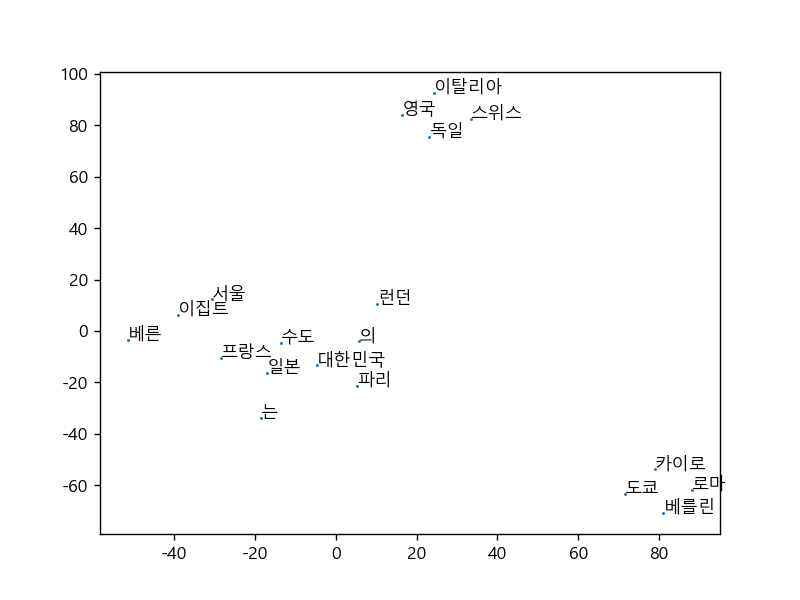

In [173]:
# Library import
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


# 간단한 Corpus
text = ['대한민국의 수도는 서울',
       '독일의 수도는 베를린',
       '프랑스의 수도는 파리',
       '스위스의 수도는 베른',
       '일본의 수도는 도쿄',
       '이탈리아의 수도는 로마',
       '영국의 수도는 런던',
       '이집트의 수도는 카이로'
       ]        

#parameters
emb_dim = 10
window_size = 2
n_negsam = 1
lr = 0.01
n_epoch = 1000

sentences, corpus, words, subs, vocab, vocab_sub, word_dict, index_dict, subs_dict, subs_index_dict = Prep().Get_clean(text) # 전처리
inputs, targets, labels = Make_pairs().Get_pairs(window_size, n_negsam) # Input / target / label 생성
center_mat, context_mat = train(inputs, targets, labels, emb_dim, lr, n_epoch) # Training
wordvec_2d = TSNEplot(context_mat.data, vocab, perplexity=5) # TNSE plotting

FastText를 이용하여 저차원 투영을 해 보았는데요, 약식 Corpus에서는 오히려 Word2Vec보다 분리도가 조금 부족한 듯 합니다. 

그러나, FastText의 진정한 강점은 OOV와 infrequent word에 있었다는 것, 기억하시죠?  
OOV에 대해서도 유사한 단어벡터를 찾아낼 수 있는지 알아보기 위해 코사인 유사도를 구하는 함수를 만들어 보았습니다.

## 6. 코사인 유사도

두 벡터 A,B 간 코사인 유사도는 $ \frac{A \cdot B}{\lVert A \rVert \lVert B \rVert} $로 구할 수 있습니다

FastText에서 subword들을 이용해서 OOV에 대한 코사인 유사도를 찾기 위해서는 아래와 같은 과정이 필요합니다.

- 새로운 단어를 subword들로 변환
- 각 변환된 subword들 중 subword vocabulary에 존재하는 것들에 대한 임베딩 벡터 찾기
- 해당 임베딩 벡터들의 평균값 구하기
- Vocabulary에 있는 임베딩 벡터들과 코사인 유사도를 계산하여 상위 n개 추출하기

In [174]:
## Cosine Similarity

import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(word, n=10):
    all_sim = []
    
    subs = Word_to_sub(word) # sub word로 분해
    subs = [i for i in subs if i in list(subs_dict.keys())] # sub_dict에 있는 sub들만 취급
    
    x_sub = [subs_dict[i] for i in subs]
    h_sub = [center_mat[:,i] for i in x_sub] # look-up table
    h = sum(h_sub).detach().numpy() 
    
    # vocab의 단어들과 유사도 비교
    for v in vocab:
        vec = context_mat[word_dict[v],:].detach().numpy()
        sim = dot(h, vec)/(norm(h)*norm(vec))
        all_sim.append(sim)
    
    top = np.argsort(all_sim)[::-1][:n]
    outword = [index_dict[i] for i in top]
    outsim = [all_sim[t] for t in top]
    
    print('-------------------------------------')
    print('Cosine Similarity of Top %d words' % n)
    print('-------------------------------------')

    for i in range(n):
        print(outword[i] + ': ' + str(outsim[i]))


In [178]:
cos_sim('도쿄')

-------------------------------------
Cosine Similarity of Top 10 words
-------------------------------------
는: 0.55463845
일본: 0.3923711
수도: 0.39181384
파리: 0.39041206
프랑스: 0.3789789
대한민국: 0.36931658
스위스: 0.36227566
런던: 0.36167532
서울: 0.3500413
독일: 0.3499485


'도쿄' 라는 단어는 corpus에 존재하므로 Word2Vec과 FastText 둘 다 임베딩 벡터를 가지고 있습니다.  
훈련된 FastText에서는 가까운 단어들로 '는', '일본', '수도' 등 꽤 정확한 결과를 보여주고 있는데요. 

아무래도 약식 corpus다 보니 모든 단어에 대해 정확하게 나오지는 않습니다만, 이정도로도 꽤 고무적입니다.

다음으로, vocabulary는 없는 단어를 입력해 보겠습니다.

In [184]:
cos_sim('토쿄')

-------------------------------------
Cosine Similarity of Top 10 words
-------------------------------------
는: 0.6342856
수도: 0.48141426
일본: 0.48125547
파리: 0.4735985
프랑스: 0.47016868
대한민국: 0.45028836
런던: 0.44021773
서울: 0.43334243
의: 0.43004078
독일: 0.42512387


'토쿄'는 vocabulary에 없는 단어임에도 불구하고 '도쿄'와 동일한 output을 내고 있습니다.  
'도쿄'와 '토쿄' 둘다 내부단어인 '쿄>'를 가지고 있으므로 '쿄>'가 임베딩된 벡터를 통해 두 단어의 유사성을 잡아낸 것이죠.

## 마치며

이처럼 FastText는 Word2Vec에서는 해결할 수 없었던 OOV에도 유연하게 대처하는 것을 알 수 있습니다.  
저는 추가적으로 네이버 영화 리뷰 데이터를 이용하여 FastText를 학습시켜서 이것저것 유사도를 찾아 보기도 했습니다.   
여유가 되신다면 더 많은 데이터셋으로 다양하게 실습해보는 것도 좋을 것 같습니다. 
